In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# This is for if we're trying to execute on a remote JupyterHub, where the pwd is set to the server root, or else I think pwd is set correctly already.
# %cd CD_Circuit/

import argparse
import numpy as np
import os
import pandas as pd
import scipy as sp
import sys
import torch
import torch.nn.functional as F
import warnings
import random
import collections

# CD-T Imports
import math
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import itertools
import operator

from torch import nn

warnings.filterwarnings("ignore")

base_dir = os.path.split(os.getcwd())[0]
sys.path.append(base_dir)

from argparse import Namespace
from methods.bag_of_ngrams.processing import cleanReports, cleanSplit, stripChars
from pyfunctions.general import extractListFromDic, readJson, combine_token_attn, compute_word_intervals, compare_same
from pyfunctions.cdt_basic import *
from pyfunctions.cdt_source_to_target import *
from pyfunctions.ioi_dataset import IOIDataset
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AutoTokenizer, AutoModel
from transformers import GPT2Tokenizer, GPT2Model
from pyfunctions.wrappers import Node, AblationSet

## Load Model

Note: Unlike with the BERT model + medical dataset objective, it is not necessary to pretrain GPT-2 to perform the IOI dataset.
GPT-2-small is already capable of performing IOI; that's part of the point of the Mech Interp in the Wild paper.
We only need to examine how it does it.

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.autograd.set_grad_enabled(False)
# Model code adapted from Callum McDougall's notebook for ARENA on reproducing the IOI paper using TransformerLens.
# This makes some sense, since EasyTransformer, the repo/lib released by the IOI guys, was forked from TransformerLens.
# In fact, this makes the reproduction a little bit more faithful, since they most likely do certain things such as 
# "folding" LayerNorms to improve their interpretability results, and we are able to do the same by using TransformerLens.
# HuggingFace, by contrast, has the most impenetrable docs and tons of outdated APIs and etc.; even their source 
# code is impossible to traverse, and I gave up on it, thankfully quickly.

from transformer_lens import utils, HookedTransformer, ActivationCache
model = HookedTransformer.from_pretrained("gpt2-small",
                                          center_unembed=True,
                                          center_writing_weights=True,
                                          fold_ln=False,
                                          refactor_factored_attn_matrices=True)
                                          

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loaded pretrained model gpt2-small into HookedTransformer


## Generate mean activations

This is not as simple as it sounds; for the IOI paper, for each individual input following a template, they ablate using the mean activations of the "ABC" dataset, generated over sentences following the same template.

In [5]:
from pyfunctions.ioi_dataset import IOIDataset

# Generate a dataset all consisting of one template, randomly chosen.
# nb_templates = 2 due to some logic internal to IOIDataset:
# essentially, the nouns can be an ABBA or ABAB order and that counts as separate templates.
ioi_dataset = IOIDataset(prompt_type="ABBA", N=50, tokenizer=model.tokenizer, prepend_bos=False, nb_templates=2)

# This is the P_ABC that is mentioned in the IOI paper, which we use for mean ablation.
# Importantly, passing in prompt_type="ABC" or similar is NOT the same thing as this.
abc_dataset = (
    ioi_dataset.gen_flipped_prompts(("IO", "RAND"))
    .gen_flipped_prompts(("S", "RAND"))
    .gen_flipped_prompts(("S1", "RAND"))
)

logits, cache = model.run_with_cache(abc_dataset.toks) # run on entire dataset along batch dimension

attention_outputs = [cache['blocks.' + str(i) + '.hook_attn_out'] for i in range(12)]
attention_outputs = torch.stack(attention_outputs, dim=1) # now batch, head, seq, d_model
mean_acts = torch.mean(attention_outputs, dim=0)
mean_acts.shape

2024-09-16 17:36:23.065044: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-16 17:36:25.757659: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


torch.Size([12, 20, 768])

In [6]:
cache.keys()

dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_pre', 'block

In [62]:
len(ioi_dataset.io_tokenIDs)

50

In [7]:
logits, cache = model.run_with_cache(ioi_dataset.toks) # run on entire dataset along batch dimension
l = logits.cpu().numpy()


In [8]:
# logits[ioi_dataset.io_tokenIDs]
# out[i] = logits[i, 16, io_tokenIDs[i]]
       
'''
out[i][j][k] = input[index[i][j][k]][j][k]  # if dim == 0
out[i][j][k] = input[i][index[i][j][k]][k]  # if dim == 1
out[i][j][k] = input[i][j][index[i][j][k]]  # if dim == 2
'''
l = logits.cpu().numpy()
for i in range(50):
    io_score = l[i, -2, ioi_dataset.io_tokenIDs[i]]
    s_score = l[i, -2, ioi_dataset.s_tokenIDs[i]]
    print(io_score - s_score)

-0.061800003
3.4876509
2.762066
4.6025076
4.3067627
3.7013159
5.124916
2.8641872
2.2746115
4.2477646
5.069476
4.032571
4.266741
0.6383743
3.0531712
3.6856441
4.2407722
4.325715
5.227028
3.5177307
2.6748514
3.455246
1.1930981
3.0591507
3.9899797
4.2289467
3.6776705
2.8461456
3.719221
3.4173727
3.091979
4.793
1.933568
5.90215
5.956812
3.3546934
4.845831
3.4135513
3.018445
5.829817
3.1500616
1.8675127
2.0012827
3.2550507
3.72783
3.1797886
3.3666992
6.708233
2.4053087
2.652094


In [29]:

# source_list = [Node(0, 0, 0), Node(1, 1, 1)]
# target_nodes = [(7, 0, 1)]

text = ioi_dataset.sentences[0]
encoding = model.tokenizer.encode_plus(text, 
                                 add_special_tokens=True, 
                                 max_length=512,
                                 truncation=True, 
                                 padding = "longest", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device)
encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
input_shape = encoding_idxs.size()
extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)
# out_decomps, target_decomps, _ = prop_GPT(encoding_idxs, extended_attention_mask, model, source_list, target_nodes, mean_acts=mean_acts, set_irrel_to_mean=True, device=device)

## Ablating last layer and determining value of irrel

In [27]:
import functools
ranges = [
        [layer for layer in range(11, 12)],
        [sequence_position for sequence_position in range(input_shape[1])],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [tuple(n for n in source_nodes)] # here, note ablation set is a single set consisting of all source nodes in (ranges)

target_nodes = []
out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_sets, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=False)

print("rel norm: ", np.linalg.norm(out_decomp[0].rel))
print("irrel norm: ", np.linalg.norm(out_decomp[0].irrel)) # should be zero, but is not

# cache activations for faster batch run
# out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

# prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
# out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)

rel norm:  3120.5266
irrel norm:  0.0


## Generate heatmap of (attn_head, layer_idx) relevance to logits at last sequence position 

In [117]:
#ioi_dataset = IOIDataset(prompt_type="ABBA", N=50, tokenizer=model.tokenizer, prepend_bos=False, nb_templates=2)

ioi_dataset = IOIDataset(prompt_type="ABBA", N=250, tokenizer=model.tokenizer, prepend_bos=False, nb_templates=2)

# This is the P_ABC that is mentioned in the IOI paper, which we use for mean ablation.
# Importantly, passing in prompt_type="ABC" or similar is NOT the same thing as this.
abc_dataset = (
    ioi_dataset.gen_flipped_prompts(("IO", "RAND"))
    .gen_flipped_prompts(("S", "RAND"))
    .gen_flipped_prompts(("S1", "RAND"))
)

logits, cache = model.run_with_cache(abc_dataset.toks) # run on entire dataset along batch dimension

attention_outputs = [cache['blocks.' + str(i) + '.hook_attn_out'] for i in range(12)]
attention_outputs = torch.stack(attention_outputs, dim=1) # now batch, head, seq, d_model
mean_acts = torch.mean(attention_outputs, dim=0)
mean_acts.shape

torch.Size([12, 20, 768])

100%|██████████| 250/250 [03:45<00:00,  1.11it/s]


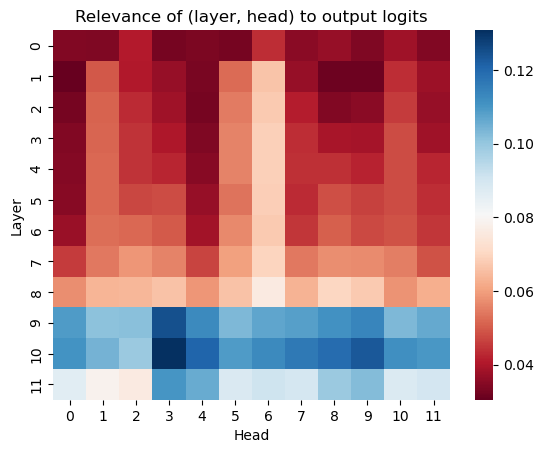

In [130]:
import functools

relevances = np.zeros((12, 12))
for i in tqdm.tqdm(range(250)): # average over samples
    text = ioi_dataset.sentences[i]

    encoding = model.tokenizer.encode_plus(text, 
                                     #add_special_tokens=True, 
                                     #max_length=16,
                                     #truncation=True, 
                                     padding = False,
                                     #padding = "max_length", 
                                     return_attention_mask=True, 
                                     return_tensors="pt").to(device)
    encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
    input_shape = encoding_idxs.size()
    extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                            input_shape, 
                                                            model,
                                                            device)
    
    end_pos = input_shape[1]-2
    #print(text)
    #print('END', model.tokenizer.convert_ids_to_tokens([encoding_idxs[0, end_pos]]))
    #print('IO', model.tokenizer.convert_ids_to_tokens([ioi_dataset.io_tokenIDs[i]]))
    #print('S', model.tokenizer.convert_ids_to_tokens([ioi_dataset.s_tokenIDs[i]]))
    
    ranges = [
            [layer for layer in range(12)], 
            [end_pos], # note fixed to last sequence position
            [attention_head_idx for attention_head_idx in range(12)]
    ]

    source_nodes = [Node(*x) for x in itertools.product(*ranges)]
    ablation_sets = [(n,) for n in source_nodes] # here the ablation set is one source node each
    target_nodes = []
    # cache activations for faster batch run
    out_decomp, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, [ablation_sets[0]], target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

    prop_fn = lambda ablation_list: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_list, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True, cached_pre_layer_acts=pre_layer_activations)
    out_decomps, target_decomps = batch_run(prop_fn, ablation_sets)
    # print([d.ablation_set for d in out_decomps]) # (0, 15, 0), (0, 15, 1)... (1, 15, 0)...
    
    for layer_idx in range(12):
        for head_idx in range(12):
            decomp = out_decomps[12 * layer_idx + head_idx]
            logits = (decomp.rel + decomp.irrel)
            io_logit = logits[0, end_pos, ioi_dataset.io_tokenIDs[i]]
            s_logit = logits[0, end_pos, ioi_dataset.s_tokenIDs[i]]
            full_score = np.abs(io_logit - s_logit)
            
            rel_io_logit = decomp.rel[0, end_pos, ioi_dataset.io_tokenIDs[i]]
            rel_s_logit = decomp.rel[0, end_pos, ioi_dataset.s_tokenIDs[i]]
            
            irrel_io_logit = decomp.irrel[0, end_pos, ioi_dataset.io_tokenIDs[i]]
            irrel_s_logit = decomp.irrel[0, end_pos, ioi_dataset.s_tokenIDs[i]]
            
            score = (rel_io_logit - rel_s_logit) / full_score
            relevances[layer_idx, head_idx] += score

relevances /= 250
s = sns.heatmap(relevances, xticklabels = range(12), yticklabels = range(12), cmap='RdBu', cbar_kws={'label': ''})
s.set(xlabel='Head', ylabel='Layer')
plt.title("Relevance of (layer, head) to output logits")
plt.show()


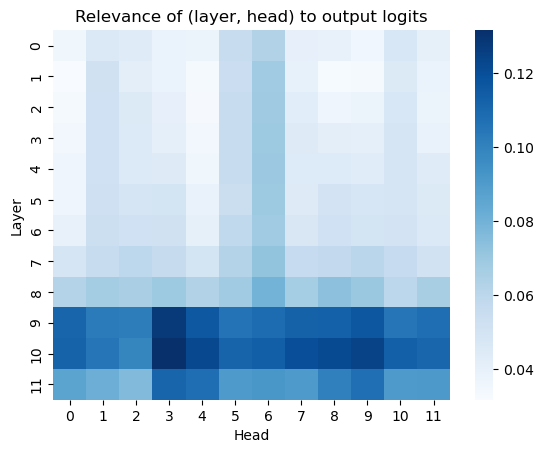

In [129]:
s = sns.heatmap(relevances, xticklabels = range(12), yticklabels = range(12), cmap='Blues', cbar_kws={'label': ''})
s.set(xlabel='Head', ylabel='Layer')
plt.title("Relevance of (layer, head) to output logits")
plt.show()

## Basic local relevance sanity check

In [65]:
import functools
'''
ranges = [
        [layer for layer in range(1)], # only the input layer
        [sequence_position for sequence_position in range(input_shape[1])],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = [Node(*x) for x in itertools.product(*ranges)]
ablation_sets = [(n,) for n in source_nodes] # here the ablation set is one source node each
'''

ablation_sets = [tuple(Node(0, pos, head) for head in range(12)) for pos in range(16)]
target_nodes = []
out_decomps, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_sets, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)


In [96]:
import matplotlib
from IPython.core.display import display, HTML
from matplotlib.colors import LinearSegmentedColormap

def normalize_word_scores(word_scores):
    neg_pos_lst = [i for i, x in enumerate(word_scores) if x < 0]
    abs_word_scores = np.abs(word_scores)
    normalized = (abs_word_scores-min(abs_word_scores))/(max(abs_word_scores)-min(abs_word_scores)) # in [0, 1] range
    for i, x in enumerate(normalized):
        if i in neg_pos_lst:
            normalized[i] = -normalized[i]
    return normalized

def colorize(words, color_array, mid=0, eps=1e-03):
    cmap_pos = LinearSegmentedColormap.from_list('', ['white', '#48b6df'])
    cmap_neg = LinearSegmentedColormap.from_list('', ['white', '#dd735b'])
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    for word, color in zip(words, color_array):
        if color > mid:
          color = matplotlib.colors.rgb2hex(cmap_pos(color)[:3])
        elif color < mid:
          color = matplotlib.colors.rgb2hex(cmap_neg(abs(color))[:3])
        colored_string += template.format(color, '&nbsp' + word + '&nbsp')
    return colored_string

In [97]:
def get_word_scores(out_decomps, ioi_dataset, data_idx):# calculate the "ioi score": the score of the correct logit minus the score of the subject logit
    logits = (out_decomps[0].rel + out_decomps[0].irrel) # 1, seq_len, 50257=d_vocab]
    io_seq_idx = ioi_dataset.io_tokenIDs[data_idx] 
    s_seq_idx = ioi_dataset.s_tokenIDs[data_idx] 

    io_logit = logits[0, -2, io_seq_idx]
    s_logit = logits[0, -2, s_seq_idx]
    full_score = np.abs(io_logit - s_logit)

    # for each source node determine the contribution of rel to the actual score
    rel_word_scores = []
    irrel_word_scores = []
    Result = collections.namedtuple('Result', ('ablation_set', 'score'))
    for idx, decomp in enumerate(out_decomps):
        assert(idx == decomp.ablation_set[0].sequence_idx)
        rel_io_logit = decomp.rel[0, -2, io_seq_idx]
        rel_s_logit = decomp.rel[0, -2, s_seq_idx]
        rel_score = rel_io_logit - rel_s_logit
        rel_norm_score = rel_score / full_score
        rel_word_scores.append(rel_norm_score)
        irrel_io_logit = decomp.irrel[0, -2, io_seq_idx]
        irrel_s_logit = decomp.irrel[0, -2, s_seq_idx]
        irrel_score = irrel_io_logit - irrel_s_logit
        irrel_norm_score = irrel_score / full_score
        irrel_word_scores.append(irrel_norm_score)
    irrel_word_scores = normalize_word_scores(irrel_word_scores)
    rel_word_scores = normalize_word_scores(rel_word_scores)
    return rel_word_scores, irrel_word_scores


In [147]:
for example_idx in range(20):
    text = ioi_dataset.sentences[example_idx]
    encoding = model.tokenizer.encode_plus(text, 
                                     #add_special_tokens=True, 
                                     #max_length=16,
                                     #truncation=True, 
                                     padding = False,
                                     #padding = "max_length", 
                                     return_attention_mask=True, 
                                     return_tensors="pt").to(device)
    encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
    input_shape = encoding_idxs.size()
    extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                            input_shape, 
                                                            model,
                                                        device)
    
    ablation_sets = [tuple(Node(0, pos, head) for head in range(12)) for pos in range(input_shape[1])]
    target_nodes = []
    
    out_decomps, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_sets, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

    rel_word_scores, irrel_word_scores = get_word_scores(out_decomps, ioi_dataset, example_idx)
    tokens = ioi_dataset.tokenized_prompts[example_idx].split('|')[:-1]
    s = colorize(tokens, rel_word_scores[:-1])
    #print(rel_word_scores[:-1])
    #s = colorize(tokens, [r - i for (r, i) in zip(rel_word_scores[:-1], irrel_word_scores[:-1])])
    display(HTML(s))

In [148]:
tokens

['Then',
 ',',
 ' Emily',
 ' and',
 ' Lindsey',
 ' had',
 ' a',
 ' lot',
 ' of',
 ' fun',
 ' at',
 ' the',
 ' store',
 '.',
 ' Lindsey',
 ' gave',
 ' a',
 ' drink',
 ' to']

In [140]:
for example_idx in range(10):
    ablation_sets = [tuple(Node(0, pos, head) for head in range(12)) for pos in range(16)]
    target_nodes = []
    text = ioi_dataset.sentences[example_idx]
    print(text)
    encoding = model.tokenizer.encode_plus(text, 
                                     add_special_tokens=True, 
                                     max_length=512,
                                     truncation=True, 
                                     padding = "longest",
                                     return_attention_mask=True, 
                                     return_tensors="pt").to(device)
    '''encoding = model.tokenizer.encode_plus(text, 
                                     #add_special_tokens=True, 
                                     #max_length=16,
                                     #truncation=True, 
                                     padding = False,
                                     #padding = "max_length", 
                                     return_attention_mask=True, 
                                     return_tensors="pt").to(device)'''
    encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
    input_shape = encoding_idxs.size()
    extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                            input_shape, 
                                                            model,
                                                        device)
    out_decomps, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_sets, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)

    rel_word_scores, irrel_word_scores = get_word_scores(out_decomps, ioi_dataset, example_idx)
    tokens = ioi_dataset.tokenized_prompts[example_idx].split('|')[:-1]
    s = colorize(tokens, rel_word_scores[:-1])
    #print(rel_word_scores[:-1])
    # s = colorize(tokens, [r - i for (r, i) in zip(rel_word_scores, irrel_word_scores)])
    display(HTML(s))
    

Then, Katherine and Angela went to the office. Angela gave a kiss to Katherine


Then, Dustin and Amy had a lot of fun at the school. Amy gave a drink to Dustin


Then, Richard and Brian went to the school. Brian gave a snack to Richard


Then, William and Jeffrey had a lot of fun at the garden. Jeffrey gave a bone to William


Then, Tyler and Brandon went to the garden. Brandon gave a basketball to Tyler


Then, Stephen and Mark went to the hospital. Mark gave a ring to Stephen


Then, Christine and Robert went to the restaurant. Robert gave a ring to Christine


Then, Amber and William went to the restaurant. William gave a kiss to Amber


Then, Erica and Jason had a lot of fun at the store. Jason gave a drink to Erica


Then, Michael and Katie had a lot of fun at the restaurant. Katie gave a snack to Michael


In [21]:
for example_idx in range(10):
    ablation_sets = [tuple(Node(0, pos, head) for head in range(12)) for pos in range(16)]
    target_nodes = []
    text = ioi_dataset.sentences[example_idx]
    encoding = model.tokenizer.encode_plus(text, 
                                     add_special_tokens=True, 
                                     max_length=512,
                                     truncation=True, 
                                     padding = "longest", 
                                     return_attention_mask=True, 
                                     return_tensors="pt").to(device)
    encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
    input_shape = encoding_idxs.size()
    extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                            input_shape, 
                                                            model,
                                                        device)
    out_decomps, _, _, pre_layer_activations = prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, ablation_sets, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)
    rel_word_scores, irrel_word_scores = get_word_scores(out_decomps, ioi_dataset, example_idx)
    tokens = ioi_dataset.tokenized_prompts[example_idx].split('|')[:-1]
    s = colorize(tokens, rel_word_scores[:-1])
    print(rel_word_scores[:-1])
    # s = colorize(tokens, [r - i for (r, i) in zip(rel_word_scores, irrel_word_scores)])
    display(HTML(s))
    

[ 0.12503366  0.06804211 -0.2677273   0.2379223   1.          0.00652583
  0.02117849  0.0179997   0.02852546  0.04209874  0.0623992   0.1255095
  0.06398715  0.12358031  0.11079159]


[-0.1552476  -0.14887741 -0.6305817   0.05864168  1.         -0.06279838
 -0.0682397  -0.06820069 -0.02659738 -0.05016475  0.00791491 -0.02818444
 -0.04597878 -0.09961167 -0.04498641]


[ 0.0425189   0.03517073  1.         -0.09745114 -0.35051733  0.02604655
  0.02128902  0.02583591  0.06288438  0.03159104 -0.0043792   0.10695977
  0.04921279  0.12951623  0.09041143]


[ 0.18934785  0.15109085  1.         -0.0344139  -0.33849844  0.07406908
  0.05657801  0.04989342  0.09208179  0.06909477  0.09598547  0.17915249
  0.06734275  0.14801477  0.11576092]


[ 0.12946582  0.12280737  1.         -0.03613115 -0.25130832  0.05250986
  0.04029482  0.03867125  0.05197566  0.04712072  0.08957664  0.10962921
  0.06660286  0.13164486  0.1481048 ]


[ 0.1941418   0.1610752   1.         -0.02469452 -0.34211576  0.06260889
  0.04523696  0.05116198  0.03708613  0.08449797  0.08677364  0.11668406
  0.07921972  0.13993913  0.13289903]


[-0.01461308 -0.00864195 -0.5357655   0.16570593  1.          0.02826415
  0.03289288  0.03200421  0.06679868  0.01457724  0.02131403 -0.02401124
  0.04435056 -0.01204948  0.00950366]


[ 0.04435787  0.02368905 -0.57629335  0.19734778  1.          0.02564937
  0.03295699  0.02718469  0.02646942  0.01844267  0.06436802  0.04170526
  0.03486887  0.07007771  0.03576522]


[ 0.2518996   0.19492106 -0.06323055  0.3893512   1.          0.15954773
  0.13111773  0.1287994   0.1649629   0.14558947  0.23237486  0.2342385
  0.10641388  0.18450557  0.21194205]


[0.17261952 0.13571991 0.08110307 0.2937489  1.         0.08936537
 0.06979498 0.06000548 0.09124836 0.09228605 0.18397167 0.13137104
 0.05967544 0.12423955 0.07967421]


In [22]:
import bisect
def interquartile_range(results, iqr_multiplier=1):
    # assume sorted in increasing order
    third_quartile = results[int(len(results) * 0.75)].score
    first_quartile = results[int(len(results) * 0.25)].score
    IQR = third_quartile - first_quartile
    outlier_score = third_quartile + iqr_multiplier * IQR
    print(third_quartile, first_quartile, outlier_score)

    by_score = operator.attrgetter('score')
    outliers = results[bisect.bisect(results, outlier_score, key=by_score):]
    return outliers

In [23]:
def n_sigma_rule(results, n=3):
    scores = [r.score for r in results]
    std_dev = np.std(scores)
    mean = np.mean(scores)
    outlier_score = mean + std_dev * n
    print(std_dev, mean, outlier_score)
    by_score = operator.attrgetter('score')
    outliers = results[bisect.bisect(results, outlier_score, key=by_score):] #bisect does a binary search, returns idx of outlier_score
    return outliers

In [61]:
results.sort(key=operator.attrgetter('score'), reverse=False)
iqr = interquartile_range(results)
print(len(iqr))
outliers = n_sigma_rule(results, n=0.5)
print(len(outliers))

0.0048643267 0.0020574331 0.007671220228075981
1
0.0033118916 0.0037320566 0.005388002377003431
1
